# Livrable 2 : Classification

|Auteur|Centre|Modification|
|---|---|---|
|Emilien Pons|Toulouse|2021/01/15|
|Nicolas Hurtevent|Toulouse|2021/01/15|
|Pierre Mazurier|Toulouse|2021/01/15|
|Pacome Chu-Lejeune|Toulouse|2021/01/15|

![logoEI_1_6.jpg](https://arras.cesi.fr/wp-content/uploads/sites/9/2019/05/Cesi_Logo_INGENIEUR_RVB-HD-500x296.jpg)

## Introduction

L'entreprise TouNum, travaillant sur la numérisation de documents, nous demande de réaliser une solution d'image captioning. L'architecture de la solution est composée de plusieurs modules, comme décrit sur le schéma suivant.

[SCHEMA]

L'architecture de la solution d'image-captionning est composée de 4 modules : un module de chargement d'image, un module déterminant si l'image est une photo ou non, un troisième module de traitement basique d'image pour la rendre plus éxploitable et un dernier module de captionning.

L'entreprise souhaite automatiser la sélection de photos pour l'annotations. Nous allons donc, dans ce document, **détailler notre méthode permettant de filtrer si une image est une photo ou non**. Cette approche utilise des réseaux de neuronnes, nous allons comparer plusieurs modèles entrainés sur les mêmes données et les comparer.

Ce modèle sera utilisé par la suite sur la solution de captionning finale.

# PLAN

- Mise en place de TensorFlow
- Fonctions utilisées
    - Initialisation du notebook
    - Préparation des datasets
- Création des modèles
    - Petite intro pour parler des CNN et comme quoi modèle simple ne font pas l'affaire
    - Modèle Baseline
        - 1. Le modèle (avec schéma)
        - 2. Analyse des résultats
    - Modèle DNN
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats DNN
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
    - Modèle CNN 1
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats CNN 1
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
    - Compromis analyse de l'over/under feating
        - 1. Qu'est ce que c'est ?
        - 2. Interprétation de notre résultat
    - Comment améliorer nos résultats
    - Modèle CNN 2 (version améliorée)
        - 1. Le modèle (avec schéma)
        - 2. Les paramètres
        - 3. La fonction de perte 
        - 4. Algorithmme d'optimisation pour l'entrainement
     - Analyse des résultats CNN 2
        - 1. Graphique analyse erreur entrainement
        - 2. Erreur de test
        - 3. Evolution de l'accuracy pour ces deux datasets
     - Conclusion

## Mise en place de TensorFlow

Dans ce livrable, nous utilisons TensorFlow. C'est un outil d'apprentissage automatique développé par Google et l'un des outils les plus utilisés en IA dans le domaine du Machine Learning. Il nous offre une bibliothèque riche qui nous permettra de créer éfficacement des réseaux de neuronnes de toute architecture. C'est également l'outil que nous avons pu prendre en main lors de nos précèdents workshops.

![logo_TS](https://www.tensorflow.org/images/tf_logo_social.png)

**NB :** Si vous ne disposez pas encore de TensorFlow, l'instalation de la bibliothèque sous votre machine est la commande suivante. Vous pouvez aussi tenter de l'installer depuis la console Anaconda en suivant la [documentation](https://docs.anaconda.com/anaconda/user-guide/tasks/tensorflow/) officielle.

In [1]:
# pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os, os.path
import pathlib

In [3]:
img_height = 256
img_width = 256
batch_size = 32

image_h = img_height
image_w = img_width
batch_s = batch_size

In [4]:
data_dir = "dataset/photo"
data_dir = pathlib.Path(data_dir)

#load images and split train and test sets
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=  0.2,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=  0.2,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s
)

Found 38974 files belonging to 2 classes.
Using 31180 files for training.
Found 38974 files belonging to 2 classes.
Using 7794 files for validation.


In [5]:
class_names =  train_set.class_names #a compl
print(class_names)
print(train_set)

['notphoto', 'photo']
<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [6]:
def plot_history(history) :
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

In [7]:
# #show exemple of an image
# images, labels = next(iter(test_set.take(1)))
# plt.imshow(images[0].numpy().astype("uint8"))

In [8]:
# print(images[0].shape)

In [9]:
# images, labels = next(iter(test_set.take(1)))
# plt.imshow(images[0].numpy().astype("uint8"))

In [10]:
# print(test_set)

In [11]:
# print(train_set)

In [12]:
# print(images.shape)
# print(labels.shape)

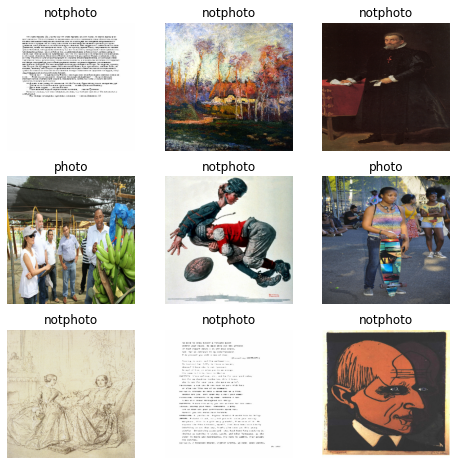

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8")) #a compl
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
# #shuffle the train set
# #add caching and prefeching optimisations
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(100000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# train_set = train_set.shuffle(100000).prefetch(buffer_size=AUTOTUNE)
# test_set = test_set.prefetch(buffer_size=AUTOTUNE)

# train_set = train_set.shuffle(100000)
# test_set = test_set

In [15]:
# for image_batch, labels_batch in train_set :
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break

In [16]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000000

# # train_set = (
# #     train_set
# #     .shuffle(BUFFER_SIZE)
# #     .batch(BATCH_SIZE, drop_remainder=True)
# #     .prefetch(tf.data.experimental.AUTOTUNE))
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_set = train_set.shuffle(100000).prefetch(buffer_size=AUTOTUNE)
# # test_set = test_set.prefetch(buffer_size=AUTOTUNE)

# train_set

In [17]:
# for image_batch, labels_batch in train_set :
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break

## Modèles

1. Modèle naïf

Nous allons établir un modèle de base qui soit le plus simple possible. Celui-ci va donc simplement toujours retourner la même classe. On remarque qu'on possède plus d'image dans la catégorie "notPhoto" que dans la catégorie "photo". Ce modèle va donc toujours classer les images en "notPhoto" et nous pourrons utiliser ses performances comme niveau de référence pour évaluer si nos modèles sont performants.

In [18]:
#retourne tt le temps que non
from sklearn.base import BaseEstimator
class NeverPhotoClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        #notPhoto est a l'index 1
        return np.ones((len(X),1), dtype=bool)
    
model_naive = NeverPhotoClassifier()

In [19]:
history =  model_naive.fit(
    train_set
)

In [20]:
# loss, accuracy = model_naive.evaluate(validation_set)

In [21]:
# model_naive_loss, model_naive_acc = model_naive.evaluate(fmnist_train_ds)
# print("Loss :", model_naive_loss)
# print("Accuracy :", model_naive_acc)

In [22]:
model_baseline = tf.estimator.BaselineClassifier(n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Nico\\AppData\\Local\\Temp\\tmp9hlzvt_t', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [23]:
# images = ()
# labels = ()
# for images, labels in train_set:  # only take first element of dataset
#     images.append = images.numpy()
#     labels.append = labels.numpy()
# print(labels)

In [24]:
# def input_fn(X, y): 
#     dataset = tf.data.Dataset.from_tensor_slices(({'X': X[:, 0], 'Y': X[:, 1]}, y))
#     dataset = dataset.shuffle(1000).batch(1000)
#     return dataset
# model_baseline.train(input_fn = lambda: input_fn(images, labels), max_steps=10)

In [25]:
# classifier.train(input_fn=input_fn_train)

### Conclu : 

Nous remarquons que ce modèle naïf retourne **notphoto** à chaque itération. 
La raison est que ???,
il va donc faloir utiliser des modèles plus adéquats tels que des réseaux de neuronnes.

In [26]:
# model = models.Sequential()
# model.add(layers.experimental.preprocessing.Rescaling(
#     1./255, input_shape=(img_height, img_width, 3) #a compl
#     )
# )
# # Couche convolutive
# model.add(
#     layers.Conv2D(16, 3, padding='same', activation='relu')#A COMPLETER
# )
# # Couche de pooling
# model.add(
#     layers.MaxPooling2D()#A COMPLETER
# )
# # Bloc convolutif ou la taille du filtre est de (32, 3)
# model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
# model.add(layers.MaxPooling2D())#A COMPLETER

# # Bloc convolutif ou la taille du filtre est de (64, 3)
# model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
# model.add(layers.MaxPooling2D())#A COMPLETER

# # Applatissement de la couche
# model.add(layers.Flatten())#A COMPLETER

# # Couche entièrement connectée (couche dense)
# model.add(layers.Dense(128, activation='relu'))
# #A COMPLETER

# # Couche entièrement connectée retournant le résultat de la classification
# model.add(layers.Dense(2))#A COMPLETER

In [27]:
# model.compile(optimizer =  'adam', #A COMPLETER
#               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #A COMPLETER
#               # loss = tf.keras.losses.SparseCategoricalCrossentropy(), #A COMPLETER
#               metrics=['accuracy'])

# model.summary()

In [28]:
# epochs=10
# history =  model.fit(
#     train_set,
#     validation_data=test_set,
#     epochs=epochs
# )

In [29]:
# epochs=10
# history =  model.fit_generator(
#     generator = train_set,
#     validation_data=test_set,
#     epochs=epochs
# )

In [30]:
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

In [31]:
# # Le modèle
# #A COMPLETER
# model_with_dropout = models.Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.5),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(2)
# ])

# # Compilation du modèle
# #A COMPLETER
# model.compile(optimizer =  'adam', #A COMPLETER
#               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #A COMPLETER
# #               loss = tf.keras.losses.SparseCategoricalCrossentropy(), #A COMPLETER
#               metrics=['accuracy'])
# # Résumé du modèle
# #A COMPLETER
# model.summary()

# # Enrainement du modèle
# #A COMPLETER
# epochs=5
# history =  model.fit(
#   train_set,
#   validation_data=test_set,
#   epochs=epochs
# )

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [32]:
#try full dense nn pour comparer

2. DNN

Dans ce second modèle, nous utilisons un [DNN](https://en.wikipedia.org/wiki/Deep_learning#Deep_neural_networks) (deep neural network). C'est une catégories de [ANN](https://en.wikipedia.org/wiki/Artificial_neural_network) composé de plusieurs couches. Dans notre cas, notre DNN est composé d'une couche Flatten et de deux couches Dense.
Celà permet de tester des modèles très simple pour classifier de manière binaire.

In [33]:
model_dense = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [34]:
model_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25165952  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 25,166,210
Trainable params: 25,166,210
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_dense.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=20
history =  model_dense.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/20
975/975 [==============================] - 304s 312ms/step - loss: 11.5848 - accuracy: 0.6880 - val_loss: 10.5854 - val_accuracy: 0.7558
Epoch 2/20
975/975 [==============================] - 302s 310ms/step - loss: 4.6485 - accuracy: 0.7081 - val_loss: 1.3472 - val_accuracy: 0.7773oss: 4.6614 
Epoch 3/20
975/975 [==============================] - 296s 304ms/step - loss: 1.9573 - accuracy: 0.7417 - val_loss: 1.3548 - val_accuracy: 0.7765
Epoch 4/20
975/975 [==============================] - 287s 294ms/step - loss: 1.0871 - accuracy: 0.7575 - val_loss: 0.4993 - val_accuracy: 0.7846
Epoch 5/20
975/975 [==============================] - 250s 257ms/step - loss: 0.5504 - accuracy: 0.7876 - val_loss: 0.4462 - val_accuracy: 0.7801
Epoch 6/20
975/975 [==============================] - 248s 255ms/step - loss: 0.4150 - accuracy: 0.8103 - val_loss: 0.3936 - val_accuracy: 0.8106
Epoch 7/20
975/975 [==============================] - 271s 278ms/step - loss: 0.3984 - accuracy: 0.8110 - val_

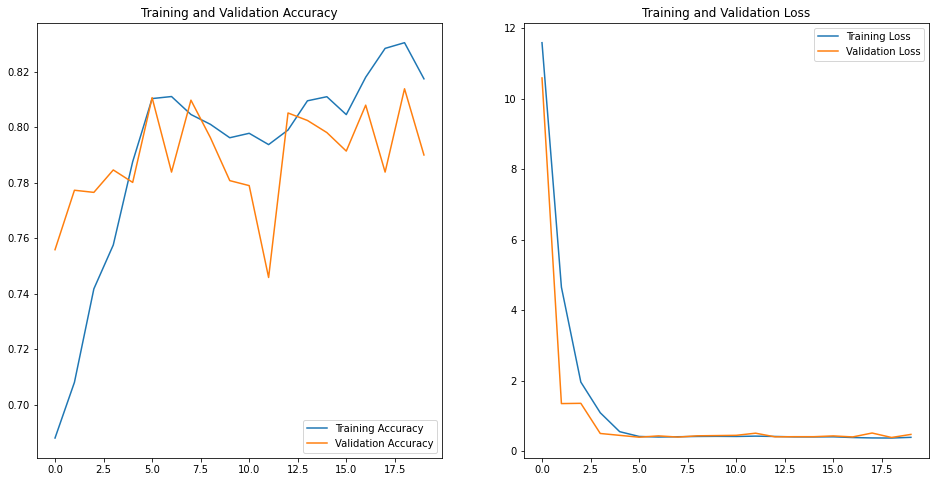

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_dnn_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

//Conclu : 
Bien que le DNN soit un réseau de neuronne très simple, il ne permet pas encore d'obtenir des résultats satisfaisants. Il va falloir utiliser des modèles plus spécialisés pour la classification dans le traitement d'image tels que des CNN.

3. CNN juste avec convo+pooling

Dans ce troisième modèle, nous introduisons le principe des [CNN](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif). C'est un empilement de couches de perceptrons qui vont nous aider à prétraiter et déterminer des caractéristiques à l'aide de ses deux principes : La convolution et le pooling.
- La convolution vient appliquer dynamiquement des filtres qui permettent de détecter les bords de l'image de manière optimale et de pouvoir reconnaître des formes.
- Le pooling vient à à cibler et détecter ces zones pour détecter des caractéristiques. On perd donc en résolution mais on se concentre sur une partie de l'image pour trouver son caractère. 

In [37]:
model_cnn_nopad = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='valid', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])

In [38]:
model_cnn_nopad.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model_cnn_pad_128 = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])

In [40]:
model_cnn_pad_128.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model_cnn_pad_64 = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])

In [42]:
model_cnn_pad_64.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model_cnn_nopad.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [44]:
# test du nodpad

In [ ]:
epochs=10
history =  model_cnn_nopad.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
975/975 [==============================] - 971s 996ms/step - loss: 0.3715 - accuracy: 0.8248 - val_loss: 0.2854 - val_accuracy: 0.8764
Epoch 2/10
975/975 [==============================] - 1134s 1s/step - loss: 0.2589 - accuracy: 0.8873 - val_loss: 0.2333 - val_accuracy: 0.9013
Epoch 3/10
975/975 [==============================] - 1180s 1s/step - loss: 0.1707 - accuracy: 0.9305 - val_loss: 0.2071 - val_accuracy: 0.9274
Epoch 4/10
975/975 [==============================] - 2852s 3s/step - loss: 0.1038 - accuracy: 0.9605 - val_loss: 0.2118 - val_accuracy: 0.9296
Epoch 5/10
975/975 [==============================] - 7306s 7s/step - loss: 0.0506 - accuracy: 0.9816 - val_loss: 0.2792 - val_accuracy: 0.9288
Epoch 6/10
166/975 [====>.........................] - ETA: 1:39:34 - loss: 0.0500 - accuracy: 0.9821

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_nopad_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# test du pad 128

In [ ]:
epochs=10
history =  model_cnn_pad_128.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_pad_128_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# test du pad 64

In [ ]:
epochs=10
history =  model_cnn_pad_64.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_pad_64_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

//Conclu :
Bien que le CNN fournisse de très bonnes accuracy, la différence entre le jeux d'entrainement et le jeux de test sur le graphique nous montre qu'il y a énormément d'overfeating.
L'overfeating est très récurent en Machine Learning, et fort heureusement, il existe de nombreuses méthodes pour l'atténuer. Nous allons donc en utiliser.

## Modèle 2 : ajout du dropout

Le premier paramètre que nous utilisons pour améliorer notre CNN est le Dropout. Le Dropout est ///INSERER TRAVAIL PACOME SUR LE DROPOUT ICI

Nous rajoutons donc une couche de Dropout à notre modèle.

In [ ]:
model_cnn_dropout = models.Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [ ]:
model_cnn_dropout.summary()

In [ ]:
model_cnn_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=20
history =  model_cnn_dropout.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_dropout_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

//Conclu : 
Le dropout a rendu plus réaliste notre jeux de données, les données sont un peu plus proche du jeux de test mais c'est encore insufissant.

## Modèle 3 : dropout + data augmentation
Pour palier à cette insufissance, nous allons rajouter à notre modèle précèdent le principe du Data Augmentation.
Le Data Augmentation est //INSERER TRAVAIL DE PACOME ICI

In [ ]:
data_augmentation = models.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(image_h, image_w, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(height_factor= 0.1)
  ]
)

In [ ]:
model_cnn_dropout_augmentation = models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [ ]:
model_cnn_dropout_augmentation.compile(optimizer =  'adam', #A COMPLETER
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #A COMPLETER
              # loss = tf.keras.losses.SparseCategoricalCrossentropy(), #A COMPLETER
              metrics=['accuracy'])

In [ ]:
model_cnn_dropout_augmentation.summary()

In [ ]:
epochs=20
history =  model_cnn_dropout_augmentation.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
model_cnn_dropout_augmentation_acc = val_acc

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

//Conclusion : 
Les résultats sont mantenant bien plus cohérents et satisfaisons. Notre modèle est entrainé correctement avec une très bonne accuracy. 

6. Divers sur l'overfeating

Il existe d'autres méthodes que le Dropout et le Data Augmentation pour rendre nos résultats dans l'overfeating. //Insérer travail de pacome ici

In [ ]:
#on peut faire un tableau comparatif des modèles
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")

In [ ]:
X_train = ()
y_train = ()
for images, labels in train_set:  # only take first element of dataset
    X_train.append = images.numpy()
    y_train.append = labels.numpy()
print(y_train)

In [ ]:
X_test = ()
y_test = ()
for images, labels in train_set:  # only take first element of dataset
    X_test.append = images.numpy()
    y_test.append = labels.numpy()
print(y_test)

In [ ]:
dummy_clf.fit(X_train, y_train)
dummy_acc = dummy_clf.score(X_test, y_test)

In [ ]:
print(max(model_cnn_pad_64_acc))

In [ ]:
from tabulate import tabulate
print(tabulate([['Naive model', max(dummy_acc)], 
                ['DNN 128', max(model_dnn_acc)],
                ['CNN no pad 64', max(model_cnn_nopad_acc)],
                ['CNN pad 64', max(model_cnn_pad_64_acc)],
                ['CNN pad 128', max(model_cnn_pad_128_acc)],
                ['CNN pad 64 + dropout', max(model_cnn_dropout_acc)],
                ['CNN pad 64 + dropout + data augmentation', max(model_cnn_dropout_augmentation_acc)],
               ], headers=['Model', 'Accuracy']))

In [ ]:
#pas hésiter a ref les papier qui montrenet que tel modèle marche le mieux (et coup de bol c'est le notre)

In [ ]:
#grille d'éval : 1 implé (bon params et explication adaptée),2 description de l'archi et visualisation des résultats : dessin de l'archi,graph de compa pour chaque modèle et commentaire. on a sans rien, aved dropout et avec data augment. 3 conclue : points forts et faibles et piste d'amélio (style transfer learning)

In [ ]:
# on a un clssif binaire donc on a 1 neurone en output et on mesure l'accuracy avec metrics=tf.metrics.BinaryAccuracy(threshold=0.0))